<a href="https://colab.research.google.com/github/ArsalaanAhmad/Pseunomia-Detection/blob/main/Pseumonia_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initializing Kaggle API & Processing Data

In [ ]:
from google.colab import files
files.upload()  # Click to upload the kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"justarsalaan","key":"357fe322dbc69865fd108f92814023d9"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image


## **Exploratory Data Analysis**
it's generally a good idea to explore the data before deriving any Machine Learning Models off it, this ensures that the data is consistent and doesn't include anomalies that could be harmful to the accuracy.


### Initialization and Sampling

Classes in training set: ['NORMAL', 'PNEUMONIA']
Number of images in NORMAL: 1341
Number of images in PNEUMONIA: 3875


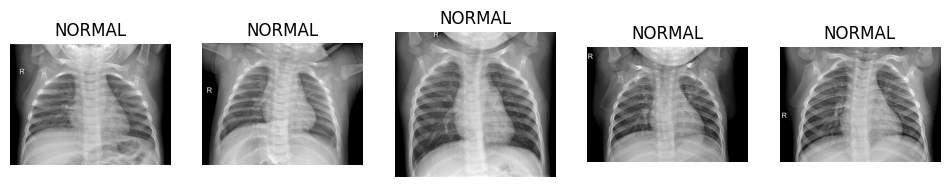

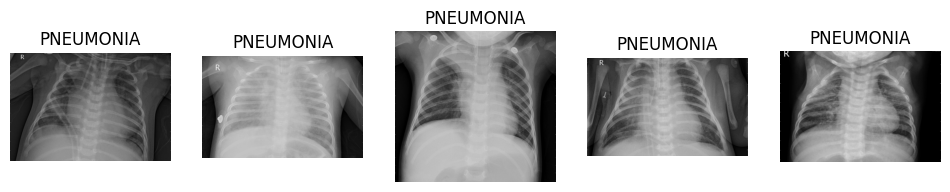

In [ ]:
train_dir = '../content/chest_xray/train'
test_dir  = '../content/chest_xray/test'
val_dir = '../content/chest_xray/val'

# Classes in training set
train_classes = os.listdir(train_dir)
print(f"Classes in training set: {train_classes}")

# Number of images in each class
for label in train_classes:
    print(f"Number of images in {label}: {len(os.listdir(os.path.join(train_dir, label)))}")

# show some images
def show_sample_images(class_name, dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_dir)[:5]  # Show 5 sample images
    plt.figure(figsize=(12, 6))
    for i, img_name in enumerate(images):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(class_name)
        plt.axis('off')
    plt.show()

# Show samples from NORMAL and PNEUMONIA classes
show_sample_images('NORMAL', train_dir)
show_sample_images('PNEUMONIA', train_dir)

### Image Size Distribution
Check if all the images are of the same size to maximize accuracy & efficiency.

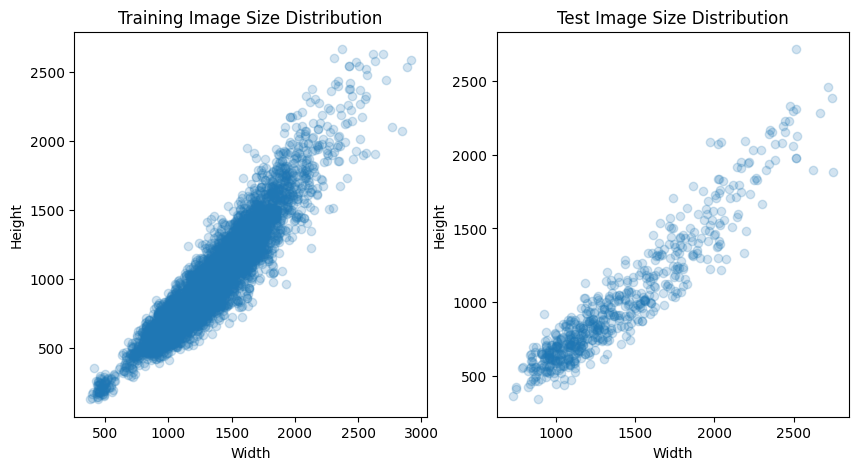

In [ ]:
def image_size_distribution(directory):
    sizes = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            img = Image.open(img_path)
            sizes.append(img.size)
    return sizes

train_sizes = image_size_distribution(train_dir)
test_sizes = image_size_distribution(test_dir)

# Convert sizes to an array
train_sizes = np.array(train_sizes)
test_sizes = np.array(test_sizes)

# Plot image size distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Training Image Size Distribution")
plt.scatter(train_sizes[:, 0], train_sizes[:, 1], alpha=0.2)
plt.xlabel("Width")
plt.ylabel("Height")

plt.subplot(1, 2, 2)
plt.title("Test Image Size Distribution")
plt.scatter(test_sizes[:, 0], test_sizes[:, 1], alpha=0.2)
plt.xlabel("Width")
plt.ylabel("Height")

plt.show()

The Conclusions we can draw from this is that:
1. The Aspect Ratio is constant, since the scatter graph shows a correlation that resembles a straight Line.
2. The Test data is more consistent in size than the training data.

### Class Size Distribution
To check for any class imbalance, examine how many images belong to each class (e.g., NORMAL vs. PNEUMONIA). This is critical because class imbalance can lead to biased models that favor the majority class. We will also check how many of these are bacterial and Viral

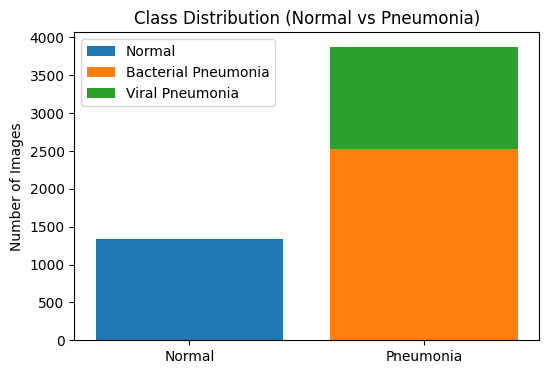

In [ ]:


# Paths to dataset directories
pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')
normal_dir = os.path.join(train_dir, 'NORMAL')

# Count normal cases
normal_cases = len(os.listdir(normal_dir))

# Count bacterial and viral pneumonia cases based on file names
bacterial_cases = 0
viral_cases = 0
for img_name in os.listdir(pneumonia_dir):
    if 'bacteria' in img_name:
        bacterial_cases += 1
    elif 'virus' in img_name:
        viral_cases += 1

# Data for the bar plot
labels = ['Normal', 'Pneumonia']
bacterial = [0, bacterial_cases]  # No bacterial in 'Normal'
viral = [0, viral_cases]  # No viral in 'Normal'
normal = [normal_cases, 0]  # No normal in 'Pneumonia'

# Create stacked bar plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(labels, normal, label='Normal')
ax.bar(labels, bacterial, bottom=normal, label='Bacterial Pneumonia')
ax.bar(labels, viral, bottom=[i+j for i,j in zip(normal, bacterial)], label='Viral Pneumonia')

# Add labels and title
plt.title('Class Distribution (Normal vs Pneumonia)')
plt.ylabel('Number of Images')
plt.legend()

# Show the plot
plt.show()

#### Some points to note here :
1. There is a **significant imbalance** between the Normal and Pneumonia cases.

2. The Normal class has far fewer images compared to the combined Pneumonia cases. This is a common scenario in medical datasets, where disease cases are often over-represented.

3. The dataset contains more bacterial infection cases, which might influence the model's learning. If not handled correctly, the model could be **biased** toward predicting bacterial pneumonia over viral pneumonia. However, both the cases are **well represented**.

## **Data Augmentation**

To prevent overfitting and improve the model’s generalization ability, you can apply data augmentation during training. This creates slightly altered versions of the images (e.g., by rotating, flipping, or zooming) to artificially expand the dataset. This will potentially solve the significant imbalance between our normal cases and Pneumonic Cases.

Found 1341 images belonging to 1 classes.
Found 3875 images belonging to 1 classes.


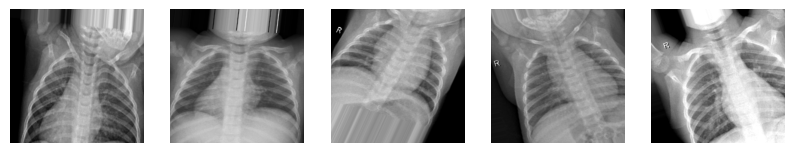

In [ ]:
# Create ImageDataGenerator for the Normal class with augmentation
normal_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,             # Rotate images randomly by 20 degrees
    width_shift_range=0.2,         # Shift width by 20%
    height_shift_range=0.2,        # Shift height by 20%
    shear_range=0.2,               # Shear transformation
    zoom_range=0.2,                # Zoom in/out
    horizontal_flip=True,          # Flip horizontally
    brightness_range=[0.8, 1.2]    # Adjust brightness
)

# Create ImageDataGenerator for Pneumonia class without augmentation
pneumonia_datagen = ImageDataGenerator(rescale=1./255)

# Set up generators for both classes
normal_generator = normal_datagen.flow_from_directory(
    train_dir,                     # Path to training data
    classes=['NORMAL'],            # Apply to the 'NORMAL' class only
    target_size=(224, 224),         # Resize to 224x224
    batch_size=32,
    class_mode='binary'
)

pneumonia_generator = pneumonia_datagen.flow_from_directory(
    train_dir,                     # Path to training data
    classes=['PNEUMONIA'],         # Apply to the 'PNEUMONIA' class only
    target_size=(224, 224),         # Resize to 224x224
    batch_size=32,
    class_mode='binary'
)

def combine_generators(normal_gen, pneumonia_gen):
    while True:
        normal_images, normal_labels = normal_gen.next()
        pneumonia_images, pneumonia_labels = pneumonia_gen.next()

        # Combine the two batches
        combined_images = np.concatenate((normal_images, pneumonia_images), axis=0)
        combined_labels = np.concatenate((normal_labels, pneumonia_labels), axis=0)

        yield combined_images, combined_labels

# Create combined generator
combined_generator = combine_generators(normal_generator, pneumonia_generator)

import matplotlib.pyplot as plt

# Display a few augmented normal images
def visualize_augmentation(generator):
    images, labels = next(generator)

    plt.figure(figsize=(10, 10))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    plt.show()

visualize_augmentation(normal_generator)

## **Building our ResNet50 Model**


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size
IMG_SIZE = 224  # Set the size to be consistent with ResNet

# Load the ResNet152V2 pre-trained model
base_model = ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False
)

# Freeze the pre-trained layers to retain learned features
base_model.trainable = False

# Define the custom head (classification layers)
def get_pretrained():

    # Input shape = [IMG_SIZE, IMG_SIZE, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Pass inputs through the pre-trained ResNet model
    x = base_model(inputs)

    # Add custom classification head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)  # Add dropout to prevent overfitting

    # Final output layer for binary classification (normal or pneumonia)
    output = layers.Dense(1, activation='sigmoid')(x)

    # Define the full model
    model = models.Model(inputs=inputs, outputs=output)

    return model

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
